# Задание №1

## Вычислить интеграл
$\int\limits_a^b \frac{1}{5-sinx} dx $
1) Самостоятельно реализовать метод трапеций
2) Использовать встроенный метод scipy.integrate
3) Получить аналитическое решение

In [1]:
#Аналитическое решение
from sympy import *
# задание функции
x = Symbol('x')
f_sym = 1/(5-sin(x))
#symbolic
F_sym = simplify(integrate(f_sym))
display(F_sym)

sqrt(6)*(atan(sqrt(6)*(5*tan(x/2) - 1)/12) + pi*floor(x/(2*pi) - 1/2))/6

In [10]:
import numpy as np
from scipy.integrate import quad
from matplotlib import pyplot as plt
import pandas as pd

def f(x):
  return 1/(5-np.sin(x))
    
# Вычисление интеграла с заданной точностью
def my_trapz(f, a, b, eps, N_max):
    #global eps, N_max
    N0 = 10
    int_prev, int_cur = 0, 0 #текущее значение и предществующее
    while (N0 <= N_max):
        h = (b-a)/N0
        x = np.linspace(a, b, N0)
        f_cur = f(x)
        int_cur = np.sum(h*(f_cur[1:]+f_cur[:-1])/2)
        # Сравнение "невязки" интегральной суммы
        if np.abs(int_cur - int_prev) < eps:
            return (N0, int_cur)
        else:
            int_prev = int_cur
            N0 *= 2
    return None, None
            
# Аналитическая первообразная
def F(x, F0):
    return -np.arctan((1-5*np.tan(x/2))/(2*np.sqrt(6)))/np.sqrt(6) + F0
    
# Численная первообразная
def int_f(f, a, b):
    global N
    h = abs(b - a)/N
    x = np.linspace(a, b, N)
    f = f(x)
    return x[1:], np.cumsum(h * (f[1:] + f[:-1])/2)
    

0.9070119986875059


,Вручную,Встроенное,$ \Delta I $
0,0.907012,9.070209e-01,0.000009
1,0.000010,2.308662e-09,0.000010


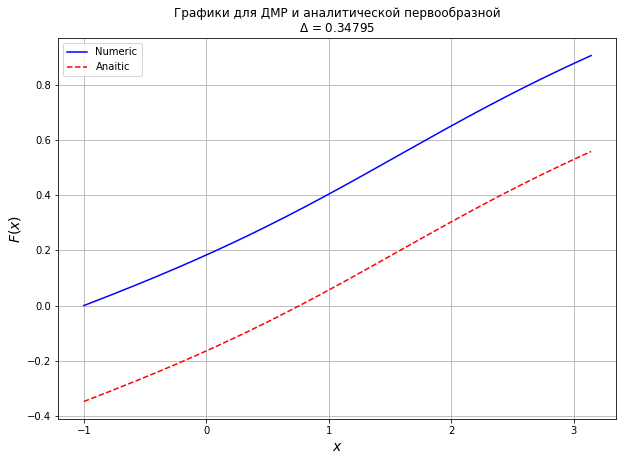

In [18]:
#численно
a, b = -1, np.pi
eps = 10**(-5)
N_max = 10**6
N, int_my_trapz = my_trapz(f, a, b, eps, N_max)
print(int_my_trapz)
int_sys, sys_err= quad(f, a, b)

int_analis = F(b, 0)- F(a, 0)

solutions = {"Вручную": [int_my_trapz, eps],
             "Встроенное": [int_sys, sys_err],
             r"$ \Delta I $": [abs(int_my_trapz - int_sys), max(eps, sys_err)]}
results = pd.DataFrame(data=solutions)
display(results)

#plotting
fig, ax = plt.subplots( figsize=(10, 7))
x, y_numerical = int_f(f, a, b)
y_analit = F(x, F(0, 0))
d = np.max(abs(y_analit - y_numerical))
#plotting
ax.plot(x, y_numerical,"b", label="Numeric")
ax.plot(x, y_analit, "r--", label = "Anaitic")
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$F(x)$', fontsize=14)
ax.set_title("Графики для ДМР и аналитической первообразной\n"+r'$\Delta$ = {0}'.format(np.round(d, 7)))
ax.grid(True)
ax.legend()
plt.show()

## Решение ОДУ

### Раздностные схемы и для ОДУ и особенности аппроксимации

### $\frac{du}{dx} + Au = f(x)$

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
        return 0#np.sin(x)

def make_mask(arr_X, lims):
    mask = (arr_X[-1] > lims[0]) & (arr_X[-1] < lims[1])
    return mask

In [20]:
def display_plot(models, ax, method):
    X = []
    U = []
    for m in models:
        A, u_0, h, T = m['param_A'], m['initial_value'], m['grid_step'], m['interval_length']
        x, u = method(A, u_0, h, T, f)
        X.append(x)
        U.append(u)
        ax.plot(x, u, label=f'h={h}') 
    ax.set_xlabel('x', loc='right', size='large')
    ax.set_ylabel('u', loc='top', size='large')
    print(len(X))
    return X, U

In [21]:
b = 10
models0 = [{'param_A': 1, 'initial_value': 1, 'grid_step': 0.3, 'interval_length': b},
          {'param_A': 1, 'initial_value': 1, 'grid_step': 0.1, 'interval_length': b},
          {'param_A': 1, 'initial_value': 1, 'grid_step': 0.01, 'interval_length': b}]

models1 = [models0[-1]]
print(models1[0]['param_A'])

1


u(x) = exp(-x)


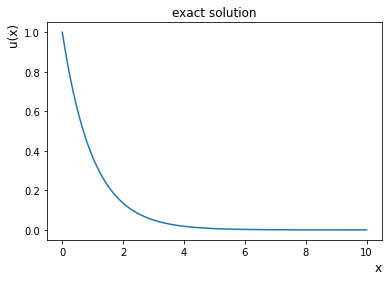

In [22]:
# точное решение
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols
from sympy.abc import x

u = Function("u");
A = models0[0]["param_A"]
u0 = models0[0]["initial_value"]
h = models0[2]["grid_step"]
N = int(np.round(b/h))

g = 0#sin(x)
eq = Derivative(u(x), x) + A*u(x) - g;
u = dsolve(eq, u(x), ics={u(0) : u0});
print(f"u(x) = {u.rhs}")

exact_X = np.linspace(0, b, N+1)
u = lambdify(x, u.rhs, "numpy")
exact_U = u(exact_X)

plt.plot(exact_X, exact_U)
plt.title("exact solution")
plt.xlabel("x",loc='right', size='large')
plt.ylabel("u(x)", loc='top', size='large')
plt.show()


### Производная вперед
$\frac{u(x+h)-u(x)}{h} = u'_+(x)$

Уравнение аппроксимируется схемой:

$\frac{u_{n+1}-u_n}{h} + Au_n = f(x_n);
u_0 = u(0); x_n = nh;$

In [23]:
def solve_next(A, u_0, h, T, f):
  step_num = int(T / h) + 1
  x = np.zeros(step_num)
  u = np.zeros(step_num)
  x[0] = 0
  u[0] = u_0
  x_curr = h
  for i in range(1, step_num):
    x[i] = x_curr
    u[i] = (1 - A * h) * u[i-1] + f(x[i-1]) * h
    x_curr += h
  return x, u

3


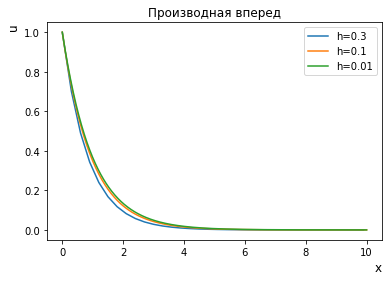

In [24]:
fig, ax = plt.subplots()
next_X, next_U = display_plot(models0, ax, solve_next)
ax.legend()
ax.set_title(r"Производная вперед")
plt.show()

### Производная назад
$\frac{u(x)-u(x-h)}{h} = u'_-(x)$

In [25]:
def solve_prev(A, u_0, h, T, f):
  step_num = int(T / h) + 1
  x = np.zeros(step_num)
  u = np.zeros(step_num)
  x[0] = 0
  u[0] = u_0
  x_curr = h
  for i in range(1, step_num):
    x[i] = x_curr
    u[i] = (u[i-1] + f(x[i])*h)/(1 + A * h)
    x_curr += h
  return x, u

3


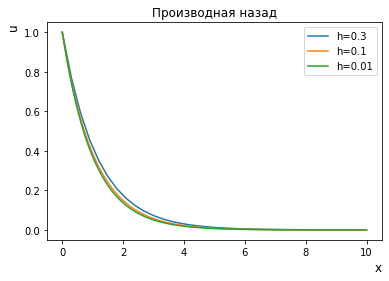

In [26]:
fig, ax = plt.subplots()
prev_X, prev_U = display_plot(models0, ax, solve_prev)
ax.legend()
ax.set_title(r"Производная назад")
plt.show()

### Симметричная производная
$ \frac{u(x+h)-u(x-h)}{2h} = u'(x)$
$u' = \frac{u(x+h)-u(x-h)}{2h};$

$u(0) = u_0;$

$\frac{u_1-u_0}{h} + A\cdot\frac{u_1+u_0}{2} = f(x_{1/2}) \Rightarrow u_1(1/h+a/2) = f(x_{1/2})$

$ u_{j+1} = 2(f(x_j) - Au_j)h + u_{j-1}$

In [27]:
def solve_midle(A, u_0, h, T, f):
    step_num = int(T / h) + 1
    x = np.zeros(step_num)
    u = np.zeros(step_num)
    x[0] = 0
    u[0] = u_0
    x_curr = h
    #посчитали первый слой через правую производную
    u[1] = u[0]*(1 - A * h) + f(x[0])*h
    #x_curr += h
    for i in range(1, step_num-1):
        x[i] = x_curr
        u[i+1] = (f(x[i]) - A*u[i])*2*h + u[i-1]
        x[i+1] = x_curr+h
        x_curr += h
    return x, u

1
3


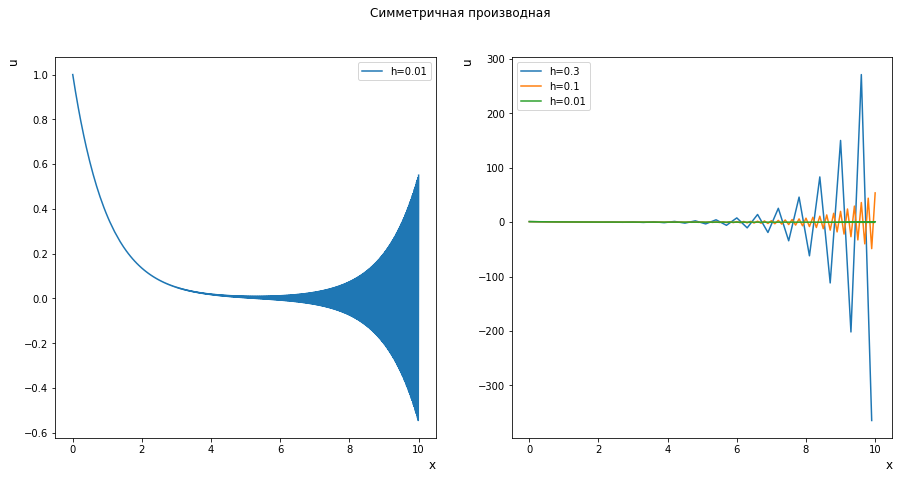

In [28]:
fig1, (ax, ay) = plt.subplots(1, 2, figsize=(15, 7))
display_plot(models1, ax, solve_midle)
midle_X, midle_U = display_plot(models0, ay, solve_midle)
ax.legend()
ay.legend()
fig1.suptitle(r"Симметричная производная")
plt.show()

### Сравнение решений разностыми схемами и аналитического

,$\Delta_{next}$,$\Delta_{prev}$,$\Delta_{mid}$
0,0.001847,0.001832,0.00007


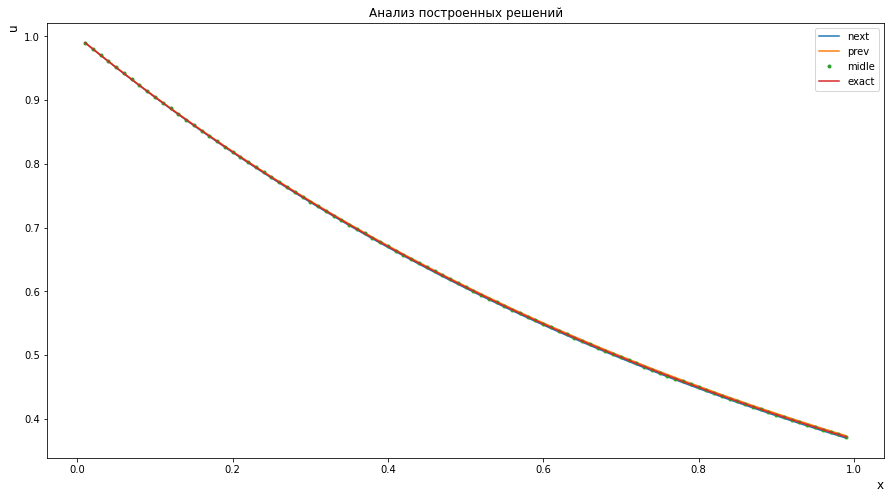

In [29]:
a = 0
b = 1
limits = [a, b]

mask = make_mask(next_X, limits)

d_next = np.max(np.abs(next_U[-1][mask]-exact_U[mask]))
d_prev = np.max(np.abs(prev_U[-1][mask]-exact_U[mask]))
d_midle = np.max(np.abs(midle_U[-1][mask]-exact_U[mask]))

differenses_between_numerical_and_exact = pd.DataFrame({r"$\Delta_{next}$": [d_next],
                                                      r"$\Delta_{prev}$": [d_prev],
                                                      r"$\Delta_{mid}$": [d_midle]})
display(differenses_between_numerical_and_exact)
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(next_X[-1][mask], next_U[-1][mask], label="next")
ax.plot(prev_X[-1][mask], prev_U[-1][mask], label="prev")
ax.plot(midle_X[-1][mask], midle_U[-1][mask], '.', label="midle")
ax.plot(exact_X[mask], exact_U[mask], label="exact")
ax.set_xlabel("x", loc="right", size="large")
ax.set_ylabel("u", loc="top", size="large")
ax.set_title("Анализ построенных решений", size="large")
ax.legend()
plt.show()